# Classifying gentrification from census data

Originally, my goal was to predict "gentrification" labels from census data.

This goal ultimately led to a few problems.

First, the "labels" I was using turned out to be compound indices, produced by combining several variables I had access to. While re-learning the compound index function isn't intrinsically bad, it doesn't really answer any research questions.

So, in response, we removed all of those features that went into the original, compound index ("cheaters"). Our goal here was to learn which features correlated with our compound index.


Let's see how we did:

In [176]:
# import jtplot module in notebook
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
jtplot.style(context='talk', fscale=1.4)
jtplot.style(ticks=True, grid=False)
%pylab inline
%load_ext autoreload
%autoreload 2
import itertools
from typing import Tuple, Dict, List, Callable
# if you get any complaints about missing dependencies, 
# comment out the line before the dependency to install it.
# (just remember to comment that line out again after installation)
# !pip3 install pandas
import pandas as pd
# !pip3 install funcy
from funcy import *
# !pip3 install numpy
import numpy as np
# Install instructions here: 
#   https://xgboost.readthedocs.io/en/latest/python/python_intro.html
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
# !pip3 install sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# !pip3 install scipy
from scipy.stats import ttest_ind
import utils

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['empty', 'where', 'iterable', 'take', 'all', 'unwrap', 'any', 'identity', 'flip', 'split', 'flatten', 'partition', 'select', 'repeat']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [177]:
udp_90_00 = pd.read_csv('data/udp9000.csv')
udp_00_13 = pd.read_csv('data/udp0013.csv')
udp_00_15 = pd.read_csv('data/udp0015.csv')
labels    = pd.read_csv('data/labels.csv')

## Tests

Testing some of our utilty functions

In [178]:
# Test `utils.align()` 
def test_align (df):
    # `align` will raise if there's an alignment issue
    f, l = utils.align(df, labels)
    return f.shape[0] == l.shape[0]
assert test_align(udp_90_00)
assert test_align(udp_00_13)
assert test_align(udp_00_15)

In [179]:
# Test `utils.X_y`
X, y = utils.X_y(udp_90_00, labels, 'disp_type_num',
           mapper=lambda x: 1 if x == 4 else 0
          )

# Dimensions are right
assert X.shape == (1580, 284)
assert y.shape == (1580,)
# Labels has 0 and 1 values
assert np.any(y == 1)
assert np.any(y == 0)
assert not np.any(y == 2)
assert not np.any(y == 3)
assert not np.any(y == 4)

In [180]:
assert utils.prior_probability(y) == 0.10126582278481013

## Performing the classification

In [181]:
def plot_confusion_matrix(
    cm: np.ndarray,
    classes: List[int],
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
    ) -> None:
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[453  48]
 [  8  13]]


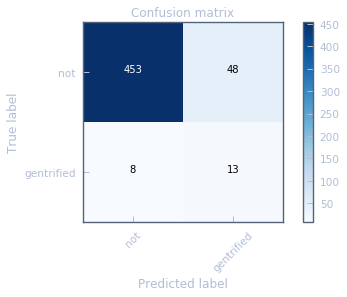

In [182]:
# method to cv + validate
X, y = utils.X_y(udp_00_15, labels, 'disp_type_num',
           mapper=lambda x: 1 if x == 4 else 0
          )

X_train, X_test, y_train, y_test =\
train_test_split(X,
                 y,
                 test_size=0.33,  # Test size should be smaller
                 random_state=0) # This "random" method will always produce
                                 # the same results, if we keep the random_state
                                 # the same. (If this is mysterious, look up PRNGs.)
        

alg, res = utils.xgb_cv(
    X_train,
    y_train,
    base_score=utils.prior_probability(y_train)
)

# alg.score(X_test, y_test)
ypred = alg.predict(X_test)
mtrx = confusion_matrix(ypred, y_test)
plot_confusion_matrix(mtrx, ['not', 'gentrified'])

## Discussion

Unfortunately, this too does not yield the outcome we expected. When properly splitting into training and validation sets, cross-validating on training and testing on validation, we find false positives - predicted gentrified, but not acutally gentrified.

We could, of course, train on all of the data in our dataset, without witholding anything. But, what would this really tell us about our underlying data? After all, our classifier could simply memorize those features in order to predict labels!


## Reflecting on the original false-positive problem

As a side-note, these results imply that the original false-positive problem in inter-period classification was almost certainly one of overfitting. The original regression model was "trained" on all of the source data. While this almost certainly produced a regression with a good fit, how well did that model generalize?

We can't know the answer to that question unless we split the data into train and tests sets, "cross-validating" our performance by training and testing a model on different splits of the data. Without doing this, our model will likely overfit to particularities of the individual period - resulting in false-positives in your original model, and false-negatives in my XGBoost model.

## Future work

There are a few ways we can go from here. The first, and simplest, is to produce labels that are not derived from the data we are interested in classifying. We could do this a number of ways: One might be to find some other way of producing "gentrification" and "exclusion" labels. Asking locals to label maps might be one way of crowd-sourcing our problem using local knowledge. Another (admittedly more neoliberal) idea might be to use rent prices as a proxy for gentrification, scraping Craigslist or some similar site. Once these labels are generated, we can return to our census data and use these as features to predict our labels.

Another option might be to use these compound indices as labels for a new classification problem. We might use as source data street view images, 311 calls, etc. The key in selecting such a dataset must be size. Our current dataset is small (under 10,000 points). A large dataset will allow us to build more robust models, which should generalize better across years.


# Clustering census data

At this moment, we have no "ground-truth" labels outside of our dataset's compoun indices, nor do we have evidence that the rest of our dataset can be used to reconstruct these labels, when these compound indices are removed.

This is a rather unsatisfying place to end. So, let's ask a different question, and see where it leads us: 

**Without looking at one topic or another, how does our data (compound indices included) "cluster" in high-dimensional space?**

It would be interesting to see what features of our dataset these clusters correlate to (and if those features have anything to do with gentrification/exclusion)!

## t-SNE

Of course, our feeble human brains cannot acutally understand high-dimensional space. So, we will use a tool called tSNE to reduce the dimensionality of our data to 2-3 dimensions, creating a "map" that we can stand a chance at interpreting.

## Understanding t-SNE: The still life

The math behind t-SNE is complex, but here's a simple thought experiment that illustrates how something like t-SNE might work.

Imagine you want to take a still-life painting of the vase on my table. Being an experimental artist, you want to capture the vase in 3 dimensions. So, you walk around the vase, meticulously capturing the vase from every possible angle.

Now, not content with stitching these photos together to create some "flat" panorama, you go about reconstructing a 3D representation of the vase from your hundreds of 2D photographs.

Let's say your high-resolution camera snaps square, black-and-white photos of 10000x10000 pixels. We can easily visualize this data: It's a black and white image! If we snapped 100 photos of our vase, we can visualize this 3-dimensional (10000x10000x100) datastructure as a series of images. Fine, no problem.

However, if we wish to construct a 3D representation from these photos, we will also need to describe each photo with its location in space (let's say Cartesian coordinates x, y, z). This makes each photo 10000x10000x3.[1] Add the camera's rotation in space (pitch, roll, yaw), and we have a 10000x10000x3x3x100 dimensional dataset. Yikes!

But wait. We *know* there is some lower-dimensional representation lurking in this high-dimensional data. Specifically, there is a 3-dimensional representation of the vase. Not only that, we *know* that we can reconstruct this representation from the higher-dimensional data. After all, our eyes are able to do this! By sampling at two points in space, we are able to "reconstruct" a 3D "representation" of the image, understanding its contours simply by looking.[2] 

So, there *is* some way to project this high dimensional data (many images) into a lower dimensional data (a single, 3D form). The high-dimensional data produced by looking (or taking photos) can be projected onto a 2- or 3-dimensional representation that explains the phenomenon quite well. [3] 

Our question is: Is there some *generic method* for reducing the dimensionality of data to two or three dimensions?

In short, and with caveats, t-SNE is such a method. The caveats are that t-SNE is /non-convex/, meaning that running the program multiple times may produce different results. However, t-SNE is amazing at allowing us to see clusters in our data that are not visible to the human eye, producing maps of n-dimensional data in two - or three dimensions.


In [183]:
import pandas as pd
from sklearn.manifold import TSNE

udp_all = pd.read_csv('data/original/udp_063017_bayareaonly_forNick_v2.csv')

In [184]:
# no strings, numbers only
# and we don't need IDs where we're going!
# finally, we'll remove all NaN (not a number) with 0,
# so we can do math on it
numerical_features_df = udp_all\
    .select_dtypes(exclude=[object])\
    .drop(['geo_fips', 'TRACT'], axis=1)\
    .fillna(0)
    
numerical_features_df.head()

pop15     pop15se  nhwht15  nhblk15  asian15  hisp15   nhwht15se  \
0   2952  112.727273     2086      106      466      99  118.181818   
1   1984   60.000000     1446       29      159     180   80.000000   
2   5377  317.575758     3339      691      726     370  200.000000   
3   4105  184.848485     2596      452      406     372  172.121212   
4   3651  181.212121     1888      888      175     518  156.969697   

    nhblk15se   asian15se    hisp15se      ...       alt_disp_type  excl_li00  \
0   44.242424  103.636364   33.939394      ...                 8.0        0.0   
1   16.363636   33.333333   46.666667      ...                 7.0        0.0   
2  120.606061  190.909091   66.060606      ...                 1.0        0.0   
3   89.696970   84.242424   72.727273      ...                 7.0        0.0   
4  112.121212   56.969697  144.242424      ...                 4.0        0.0   

   adv_excl00  gent90-00  gent00-13  zprewar13     empden13  \
0         0.0          0          0   0.125723    791.62842   
1         0.0          0          0   0.873176  23280.53700   
2         0.0          0          0   0.745769   5044.70560   
3         0.0          0          0   0.834359   5062.85740   
4         0.0          0          1   0.719976   3173.87770   

   Non-Downtown TOD13  znataff13  displihh0013  
0                   0   0.112514             0  
1                   0   0.322224             1  
2                   0   0.111578             0  
3                   0   0.050396             1  
4                   0   0.051265             1  

[5 rows x 541 columns]

In [185]:
X = numerical_features_df.as_matrix()

In [186]:
model = TSNE(
    n_components=2,  # We'll do a 2D projection
    random_state=42,  # t-SNE comes out differnetly every run. If we find some good result, we can tweak this value and see if our clusters persist, to assure our results are "really there"
    perplexity=40, # Tweakable hyperparameter (generally 0-50)
)

In [187]:
np.set_printoptions(suppress=True)
X_2d = model.fit_transform(X)
X_2d_df = pd.DataFrame(X_2d)

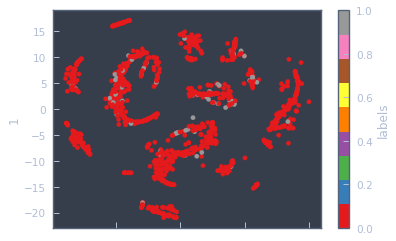

In [188]:
X_2d_df['labels'] = numerical_features_df['gent90-00']
X_2d_df.plot.scatter(x=0, y=1, c='labels', colormap='Set1')

## Interpretations

For reference, read [https://distill.pub/2016/misread-tsne/](How to use t-SNE effectively).

Yes, "interpreting" t-SNE plots are a little like "interpreting" tea leaves. What we look for here, approximately, are that different clusters exist. This indicates that there *is* some exploitable statistical structure to our data. In other words, some classifier /could/ come along and classify these data! But, with what labels? A quick search reveals that none of our labels map neatly onto the clusters that the t-SNE produced.

Discovering the labels that relate to our vectors can be difficult, to say the least. It is of course possible that these clusters don't tell us anything interesting about the world - in other words, that no set of labels worth discovering can be reliably classified using our dataset. However, these results that our data are informative and differentiable with respect to something. Whenever we discover new labels, we might try classifying them on these features!

Here's my big take-away: The labels we /produce/ from this dataset (e.g. compound indices) likely represent real statistical patterns throughout the data. We are not simply building compound indices ontop of noise and overfitting a regression to it!

# Final conclusions

This census data is interesting, but on its own, I feel it is unlikely to tell us what we need to know about gentrification and exclusion. However, our t-SNE reveals that there *are* pattenrs in these data, indicating that we could use these patterns to produce meaningful labels, and/or that these census data could be used to contextualize other data sources.

On that second point: as you move toward satelite imagery, 311 calls, or other data sources, I would recommend merging any datasets together with these census tracts. If you have, say, 1000 street-view images from each census tract, you could treat each of these census fields as categorical labels. Perhaps you can predict some of them from the street-view images!

In general, questions of ground truth abound. I think this census data, and the compound indices produced by experts (you all), are the closest we can get to ground truth about the phenomena of interest. If we can predict these variables using some other datasource, I would feel more confident that such a model would generalize to future years.


# Footnotes

[1] Well, this is certainly more highly-dimensional data, but I can think of a way to visualize it. Can you? Remember, photos consist of 3 "color" channels: red, green & blue (r,g,b). If we map a color to each Cartesian dimension (red to x, green to y, z to blue), then we can colorize each image to uniquely describe its position in space! 

[2] Of course there are possibly other inputs to our understanding of the vase (like context, language). There are also potentially other representations of the vase than spatial ones (how we feel about the vase, smell and touch of the vase, etc). Also, the brain may not actually use explicit "representations" as we use the term. Let's put these points aside right now, you can take them up with a cognitive scientist on your own time.

[3] (I hestitate to say the three-dimensional form describes the vase "in reality," because it is unclear what a vase actually *is* in reality. Suffice to say that our pheneomenal experience of vases as three-dimensional objects serves us quite well for our goals).
